In [1]:
import numpy as np
import torch
import sys
import open3d as o3d
sys.path.append('/home/as2114/code/3DBB')
from utils import get_config, load_checkpoint, average_precision_3d
from datasets import build_inference_loader
from models import build_model

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [2]:
cfg_path = "/home/as2114/code/3DBB/config/pointpillar.yaml"
checkpoint = "/mnt/gsdata/projects/panops/plant_trait_net/outputs_v5/3dbbv2_withpointpillar200/ckpt_epoch_100_train_epoch_100.pth"

import argparse

cfg_path = "/home/as2114/code/3DBB/config/pointpillar.yaml"
checkpoint = "/mnt/gsdata/projects/panops/plant_trait_net/outputs_v5/3dbbv2_withpointpillar200/ckpt_epoch_100_train_epoch_100.pth"

args = argparse.Namespace(
    cfg=cfg_path,
    opts=None,
    output_dir=None,
    skip_existing=False,
    tag=None,
    seed=0,
    resume=checkpoint,
    path_imgref_test=None,
    trait=None
)

cfg = get_config(args)

dataset, data_loader = build_inference_loader(cfg.data)

model = build_model(cfg.model).cuda()
load_checkpoint(cfg, model, None, None)
model.eval()


2025-08-26 23:07:44,524 - root - INFO - Successfully built val dataset: 40 samples
2025-08-26 23:07:44,525 - root - INFO - len dataloader val:   40


config {'type': 'PCDetectionNet', 'cfg': {'VFE': {'USE_NORM': True, 'NUM_POINT_FEATURES': 3, 'NUM_FILTERS': [64], 'WITH_DISTANCE': False, 'USE_ABSLOTE_XYZ': True}, 'MAP_TO_BEV': {'NUM_BEV_FEATURES': 64}, 'BACKBONE_2D': {'USE_CONV_FOR_FIRST_MODULE': True, 'LAYER_NUMS': [3, 5, 5], 'LAYER_STRIDES': [2, 2, 2], 'NUM_FILTERS': [64, 128, 256], 'UPSAMPLE_STRIDES': [1, 2, 4], 'NUM_UPSAMPLE_FILTERS': [128, 128, 128], 'INPUT_FEATURES': 64}, 'POINT_CLOUD_RANGE': [0, -39.68, -3, 69.12, 39.68, 1], 'VOXEL_SIZE': [0.16, 0.16, 4]}}
REgistery Registry(name=model, items={'MultimodalDetectionNet': <class 'models.multimodalmodel.MultimodalDetectionNet'>, 'MultimodalDetectionNet_v2': <class 'models.multimodalmodelv2.MultimodalDetectionNet_v2'>, 'PCDetectionNet': <class 'models.pcdetnet.PCDetectionNet'>, 'PointPillarBEVExtractor': <class 'models.pointpiller.PointPillarBEVExtractor'>})
PC BEV feature channels: 384


2025-08-26 23:07:46,556 - root - INFO - ==============> Resuming form /mnt/gsdata/projects/panops/plant_trait_net/outputs_v5/3dbbv2_withpointpillar200/ckpt_epoch_100_train_epoch_100.pth....................


Use load_from_local loader


PCDetectionNet(
  (pc_extractor): PointPillarBEVExtractor(
    (vfe): PillarVFE(
      (pfn_layers): ModuleList(
        (0): PFNLayer(
          (linear): Linear(in_features=9, out_features=64, bias=False)
          (norm): BatchNorm1d(64, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
        )
      )
    )
    (map_to_bev): PointPillarScatter()
    (backbone_2d): BaseBEVBackbone(
      (blocks): ModuleList(
        (0): Sequential(
          (0): ZeroPad2d((1, 1, 1, 1))
          (1): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), bias=False)
          (2): BatchNorm2d(64, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          (3): ReLU()
          (4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (5): BatchNorm2d(64, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          (6): ReLU()
          (7): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    

In [3]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np

def plot_boxes_rgb(image, gt_boxes, pred_boxes):
    """
    image: np.array of shape (3,H,W) or (H,W,3), RGB in [0,1] or [0,255]
    gt_boxes, pred_boxes: (N,7) arrays; only x,y,width,height needed for 2D visualization
    """
    # Convert (3,H,W) -> (H,W,3)
    if image.shape[0] == 3:
        image = image.transpose(1,2,0)

    # Normalize if needed
    if image.max() > 1.0:
        image = image / 255.0

    fig, ax = plt.subplots(1,1, figsize=(10,10))
    ax.imshow(image)

    # Draw GT boxes in green
    for box in gt_boxes:
        x, y = box[0], box[1]  # use center
        w, h = box[3], box[4]  # use dx, dy
        rect = patches.Rectangle((x-w/2, y-h/2), w, h, linewidth=2, edgecolor='g', facecolor='none')
        ax.add_patch(rect)

    # Draw predicted boxes in red
    for box in pred_boxes:
        x, y = box[0], box[1]
        w, h = box[3], box[4]
        rect = patches.Rectangle((x-w/2, y-h/2), w, h, linewidth=2, edgecolor='r', facecolor='none')
        ax.add_patch(rect)

    plt.axis('off')
    plt.show()


Pred boxes shape: torch.Size([1, 100, 7]), Pred logits shape: torch.Size([1, 100, 2])


/home/as2114/code/3DBB/models/pcdetnet.py:308: UserWarning: Using a target size (torch.Size([1, 19, 3])) that is different to the input size (torch.Size([100, 1, 3])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  F.l1_loss(pred_boxes_sample[:, None, 0:3].cuda(), gt_boxes_sample[None, :, 0:3].cuda(), reduction='none').sum(-1) +
/home/as2114/code/3DBB/models/pcdetnet.py:309: UserWarning: Using a target size (torch.Size([1, 19, 3])) that is different to the input size (torch.Size([100, 1, 3])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  F.l1_loss(pred_boxes_sample[:, None, 3:6].cuda(), gt_boxes_sample[None, :, 3:6].cuda(), reduction='none').sum(-1)


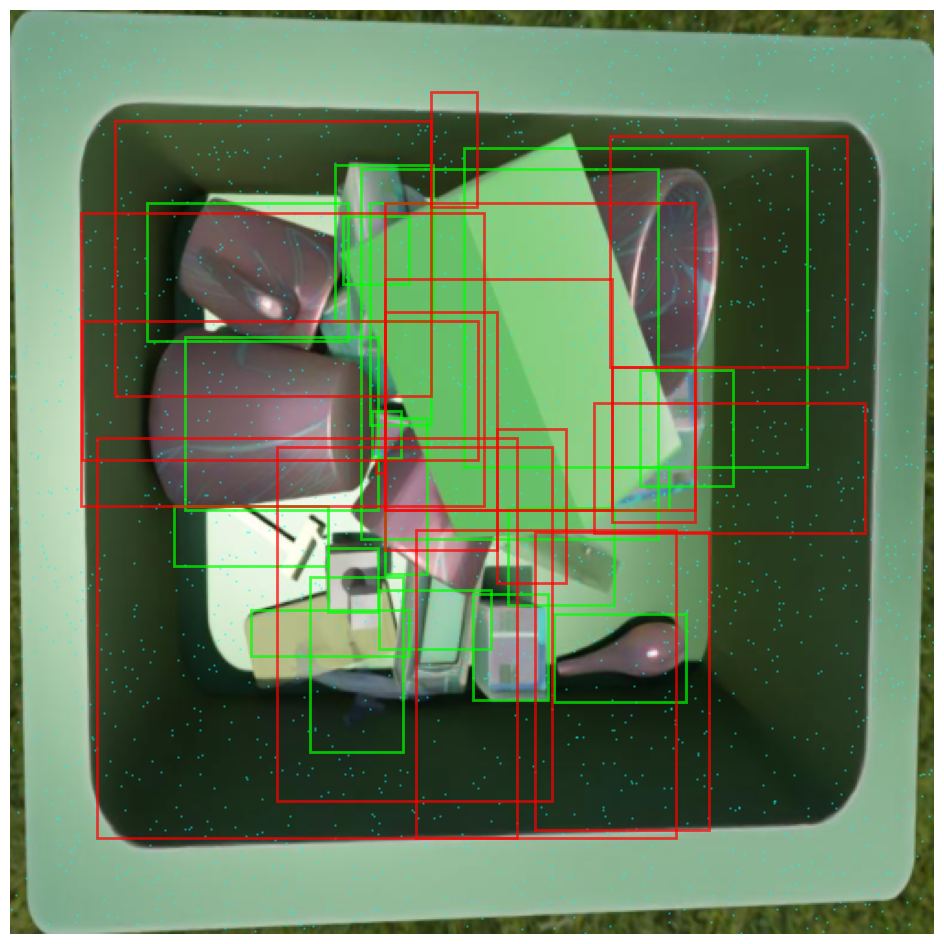

Pred boxes shape: torch.Size([1, 100, 7]), Pred logits shape: torch.Size([1, 100, 2])


/home/as2114/code/3DBB/models/pcdetnet.py:308: UserWarning: Using a target size (torch.Size([1, 12, 3])) that is different to the input size (torch.Size([100, 1, 3])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  F.l1_loss(pred_boxes_sample[:, None, 0:3].cuda(), gt_boxes_sample[None, :, 0:3].cuda(), reduction='none').sum(-1) +
/home/as2114/code/3DBB/models/pcdetnet.py:309: UserWarning: Using a target size (torch.Size([1, 12, 3])) that is different to the input size (torch.Size([100, 1, 3])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  F.l1_loss(pred_boxes_sample[:, None, 3:6].cuda(), gt_boxes_sample[None, :, 3:6].cuda(), reduction='none').sum(-1)


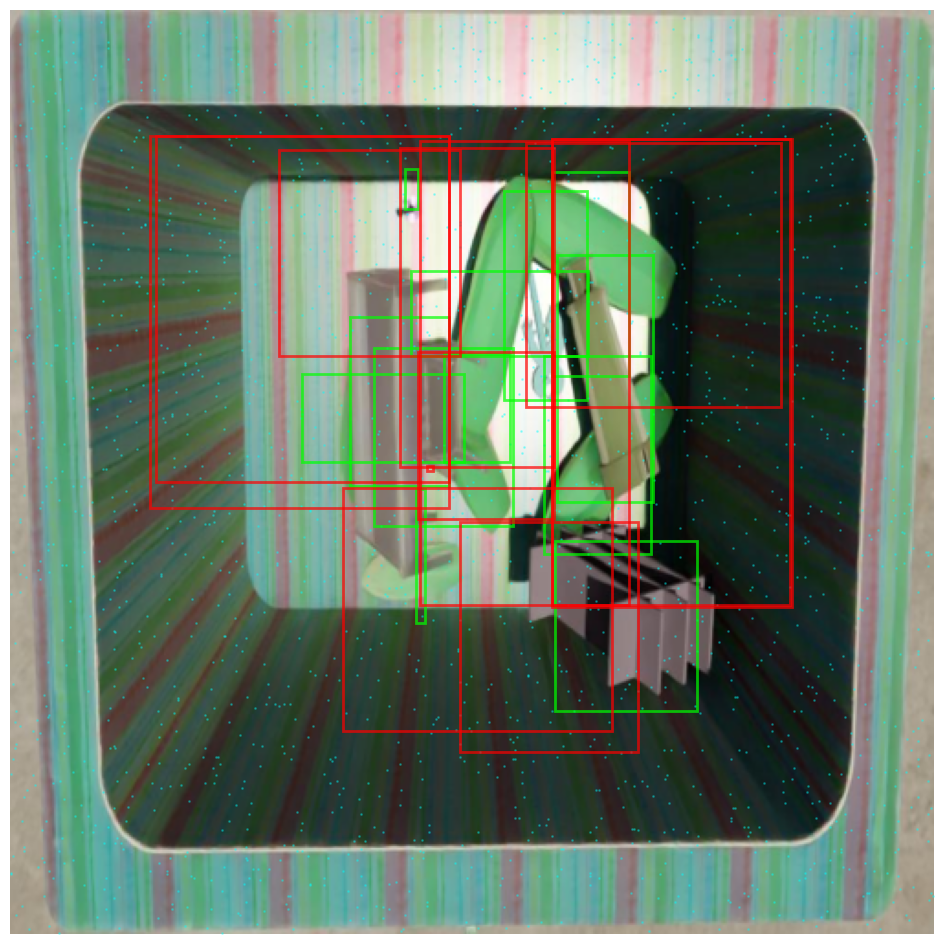

Pred boxes shape: torch.Size([1, 100, 7]), Pred logits shape: torch.Size([1, 100, 2])


/home/as2114/code/3DBB/models/pcdetnet.py:308: UserWarning: Using a target size (torch.Size([1, 5, 3])) that is different to the input size (torch.Size([100, 1, 3])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  F.l1_loss(pred_boxes_sample[:, None, 0:3].cuda(), gt_boxes_sample[None, :, 0:3].cuda(), reduction='none').sum(-1) +
/home/as2114/code/3DBB/models/pcdetnet.py:309: UserWarning: Using a target size (torch.Size([1, 5, 3])) that is different to the input size (torch.Size([100, 1, 3])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  F.l1_loss(pred_boxes_sample[:, None, 3:6].cuda(), gt_boxes_sample[None, :, 3:6].cuda(), reduction='none').sum(-1)


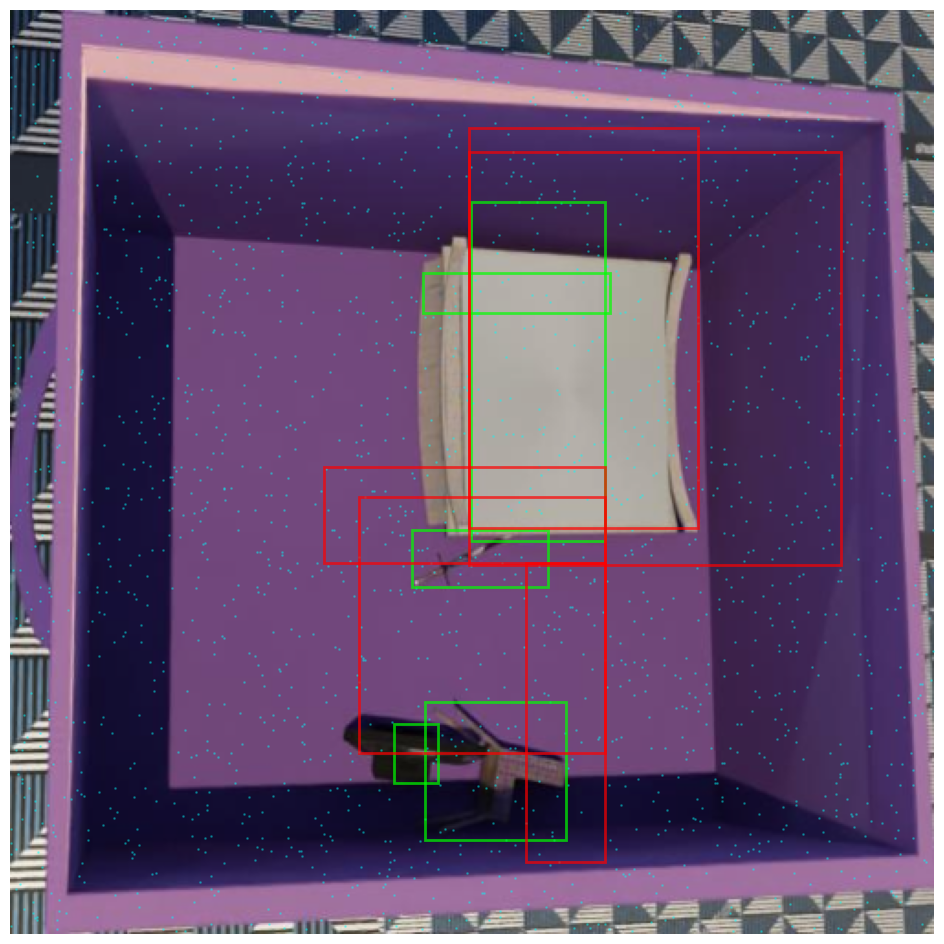

Pred boxes shape: torch.Size([1, 100, 7]), Pred logits shape: torch.Size([1, 100, 2])


/home/as2114/code/3DBB/models/pcdetnet.py:308: UserWarning: Using a target size (torch.Size([1, 7, 3])) that is different to the input size (torch.Size([100, 1, 3])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  F.l1_loss(pred_boxes_sample[:, None, 0:3].cuda(), gt_boxes_sample[None, :, 0:3].cuda(), reduction='none').sum(-1) +
/home/as2114/code/3DBB/models/pcdetnet.py:309: UserWarning: Using a target size (torch.Size([1, 7, 3])) that is different to the input size (torch.Size([100, 1, 3])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  F.l1_loss(pred_boxes_sample[:, None, 3:6].cuda(), gt_boxes_sample[None, :, 3:6].cuda(), reduction='none').sum(-1)


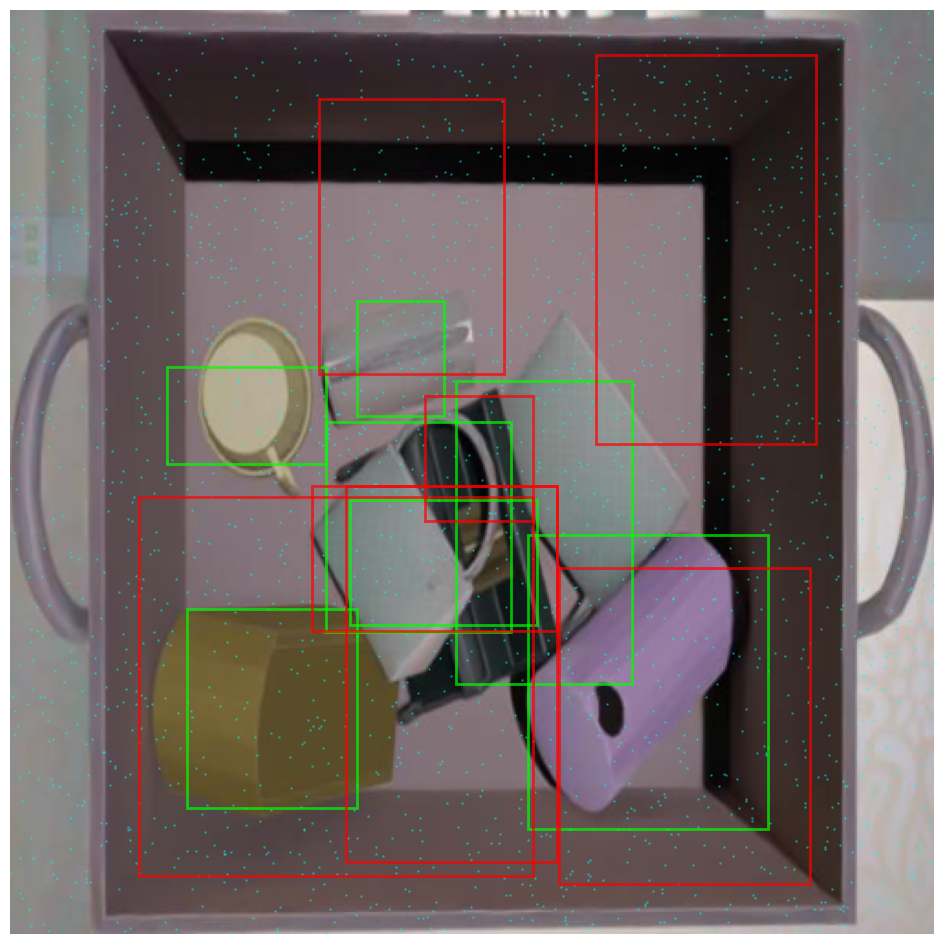

Pred boxes shape: torch.Size([1, 100, 7]), Pred logits shape: torch.Size([1, 100, 2])


/home/as2114/code/3DBB/models/pcdetnet.py:308: UserWarning: Using a target size (torch.Size([1, 21, 3])) that is different to the input size (torch.Size([100, 1, 3])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  F.l1_loss(pred_boxes_sample[:, None, 0:3].cuda(), gt_boxes_sample[None, :, 0:3].cuda(), reduction='none').sum(-1) +
/home/as2114/code/3DBB/models/pcdetnet.py:309: UserWarning: Using a target size (torch.Size([1, 21, 3])) that is different to the input size (torch.Size([100, 1, 3])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  F.l1_loss(pred_boxes_sample[:, None, 3:6].cuda(), gt_boxes_sample[None, :, 3:6].cuda(), reduction='none').sum(-1)


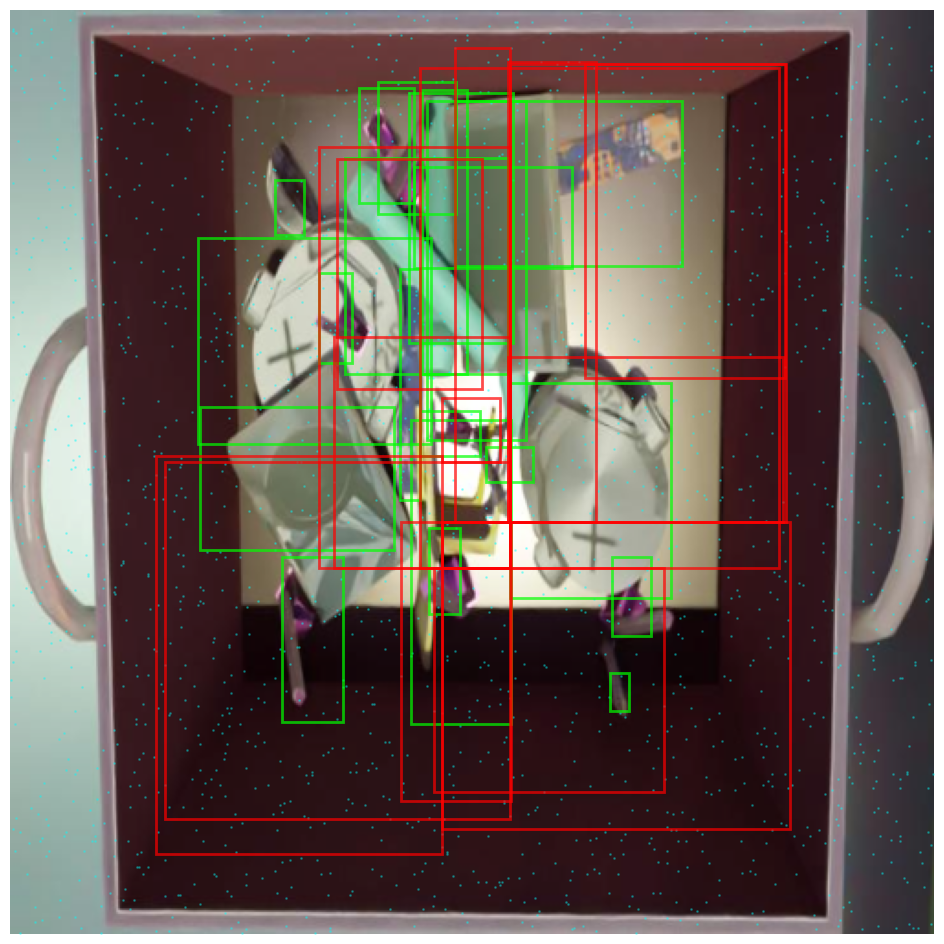

Pred boxes shape: torch.Size([1, 100, 7]), Pred logits shape: torch.Size([1, 100, 2])


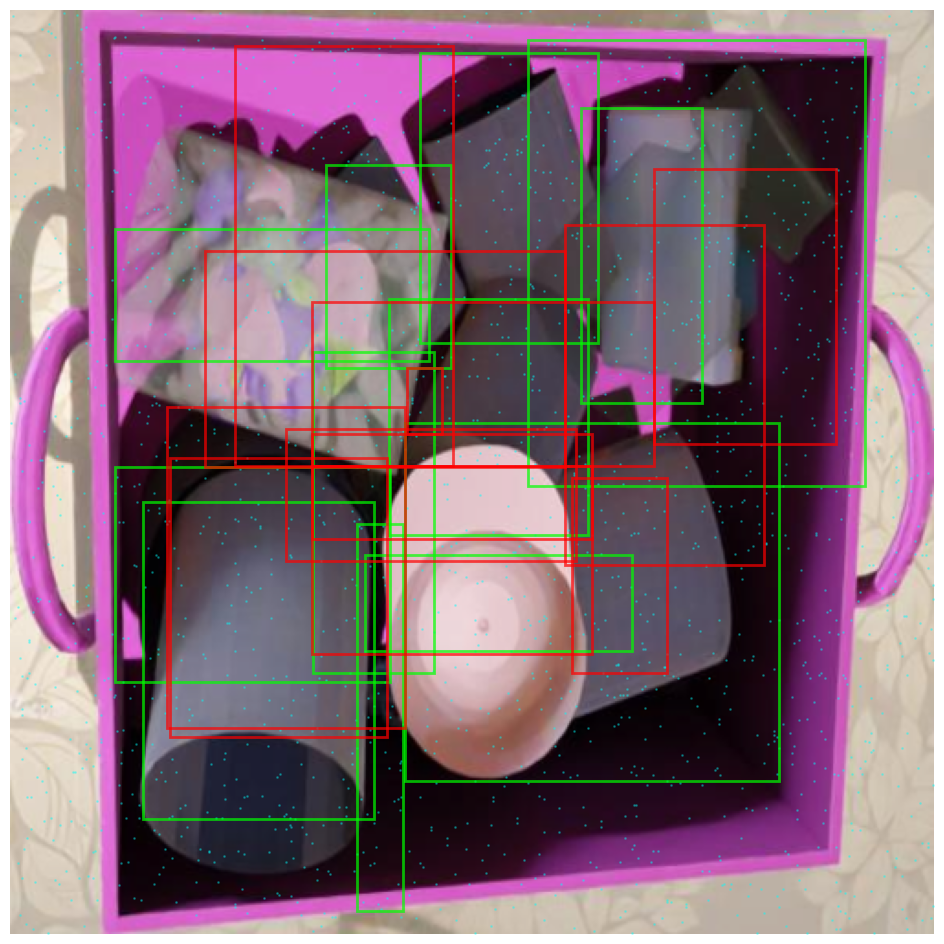

Pred boxes shape: torch.Size([1, 100, 7]), Pred logits shape: torch.Size([1, 100, 2])


/home/as2114/code/3DBB/models/pcdetnet.py:308: UserWarning: Using a target size (torch.Size([1, 1, 3])) that is different to the input size (torch.Size([100, 1, 3])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  F.l1_loss(pred_boxes_sample[:, None, 0:3].cuda(), gt_boxes_sample[None, :, 0:3].cuda(), reduction='none').sum(-1) +
/home/as2114/code/3DBB/models/pcdetnet.py:309: UserWarning: Using a target size (torch.Size([1, 1, 3])) that is different to the input size (torch.Size([100, 1, 3])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  F.l1_loss(pred_boxes_sample[:, None, 3:6].cuda(), gt_boxes_sample[None, :, 3:6].cuda(), reduction='none').sum(-1)


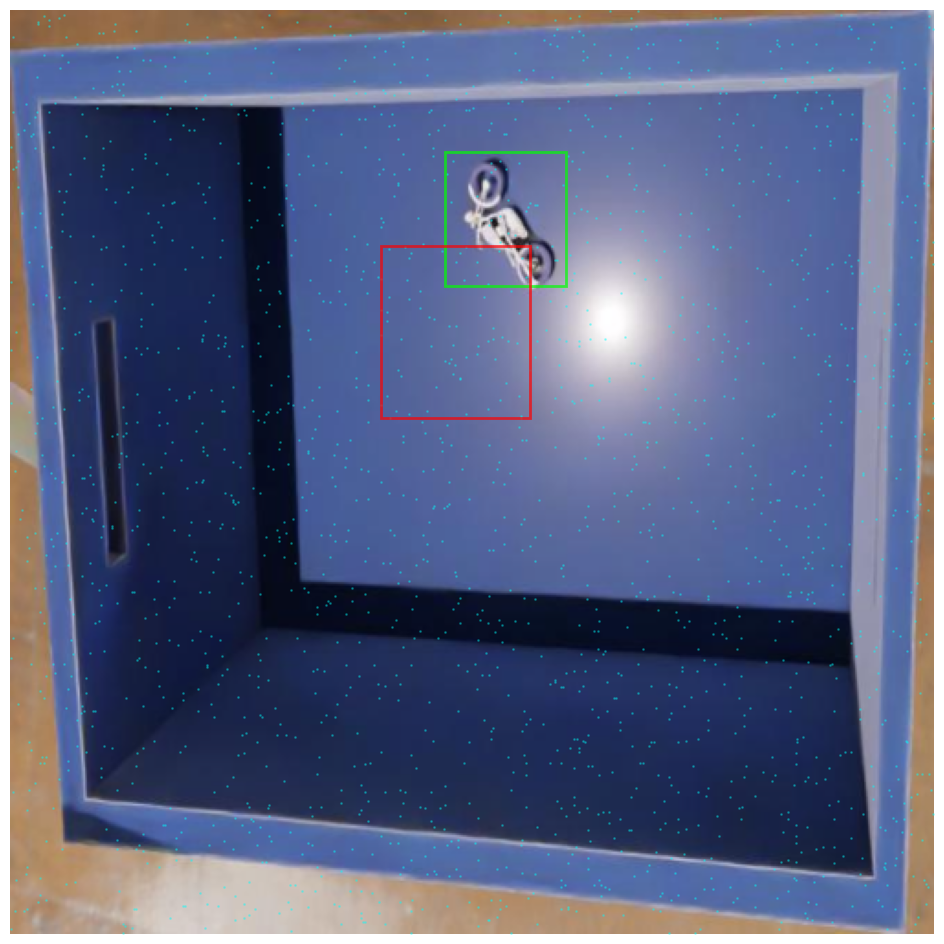

Pred boxes shape: torch.Size([1, 100, 7]), Pred logits shape: torch.Size([1, 100, 2])


/home/as2114/code/3DBB/models/pcdetnet.py:308: UserWarning: Using a target size (torch.Size([1, 2, 3])) that is different to the input size (torch.Size([100, 1, 3])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  F.l1_loss(pred_boxes_sample[:, None, 0:3].cuda(), gt_boxes_sample[None, :, 0:3].cuda(), reduction='none').sum(-1) +
/home/as2114/code/3DBB/models/pcdetnet.py:309: UserWarning: Using a target size (torch.Size([1, 2, 3])) that is different to the input size (torch.Size([100, 1, 3])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  F.l1_loss(pred_boxes_sample[:, None, 3:6].cuda(), gt_boxes_sample[None, :, 3:6].cuda(), reduction='none').sum(-1)


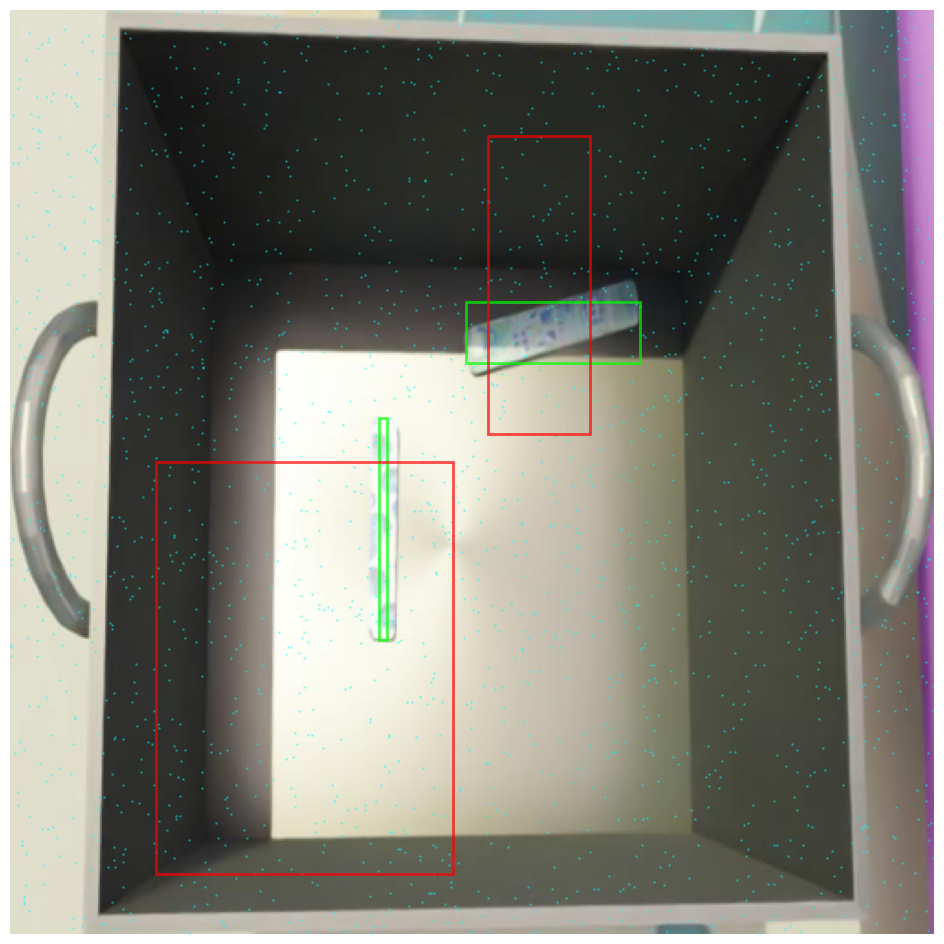

Pred boxes shape: torch.Size([1, 100, 7]), Pred logits shape: torch.Size([1, 100, 2])


/home/as2114/code/3DBB/models/pcdetnet.py:308: UserWarning: Using a target size (torch.Size([1, 6, 3])) that is different to the input size (torch.Size([100, 1, 3])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  F.l1_loss(pred_boxes_sample[:, None, 0:3].cuda(), gt_boxes_sample[None, :, 0:3].cuda(), reduction='none').sum(-1) +
/home/as2114/code/3DBB/models/pcdetnet.py:309: UserWarning: Using a target size (torch.Size([1, 6, 3])) that is different to the input size (torch.Size([100, 1, 3])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  F.l1_loss(pred_boxes_sample[:, None, 3:6].cuda(), gt_boxes_sample[None, :, 3:6].cuda(), reduction='none').sum(-1)


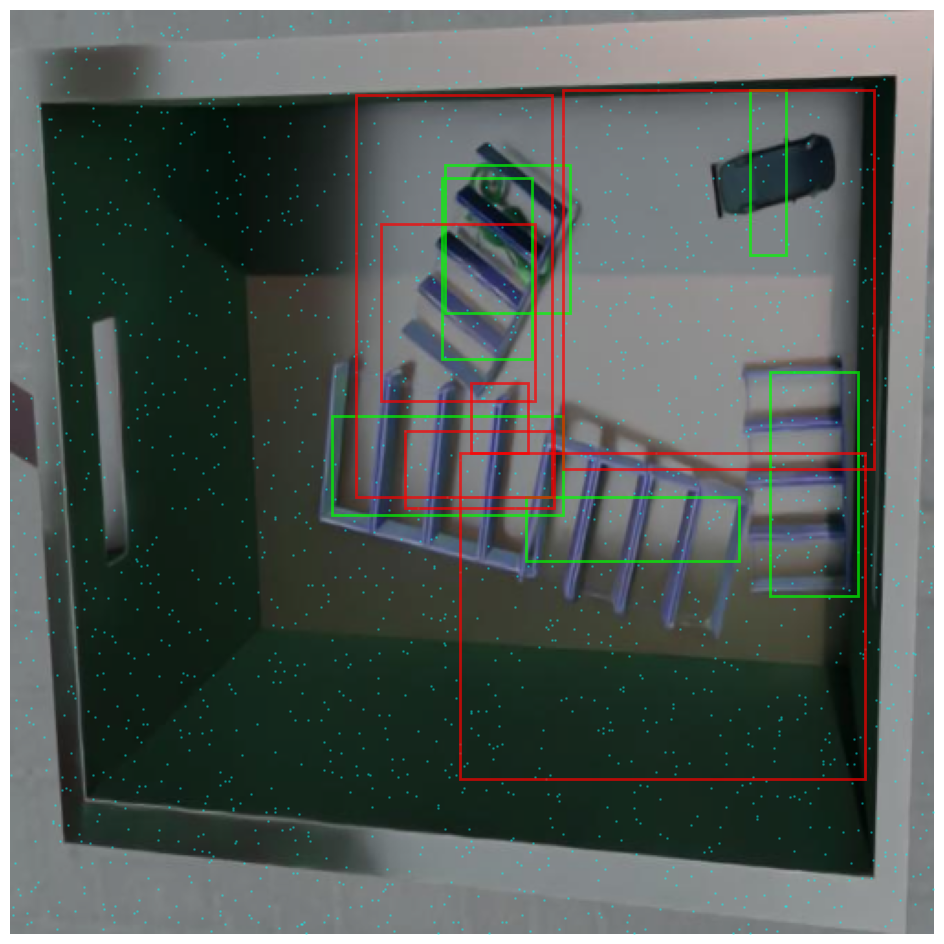

Pred boxes shape: torch.Size([1, 100, 7]), Pred logits shape: torch.Size([1, 100, 2])


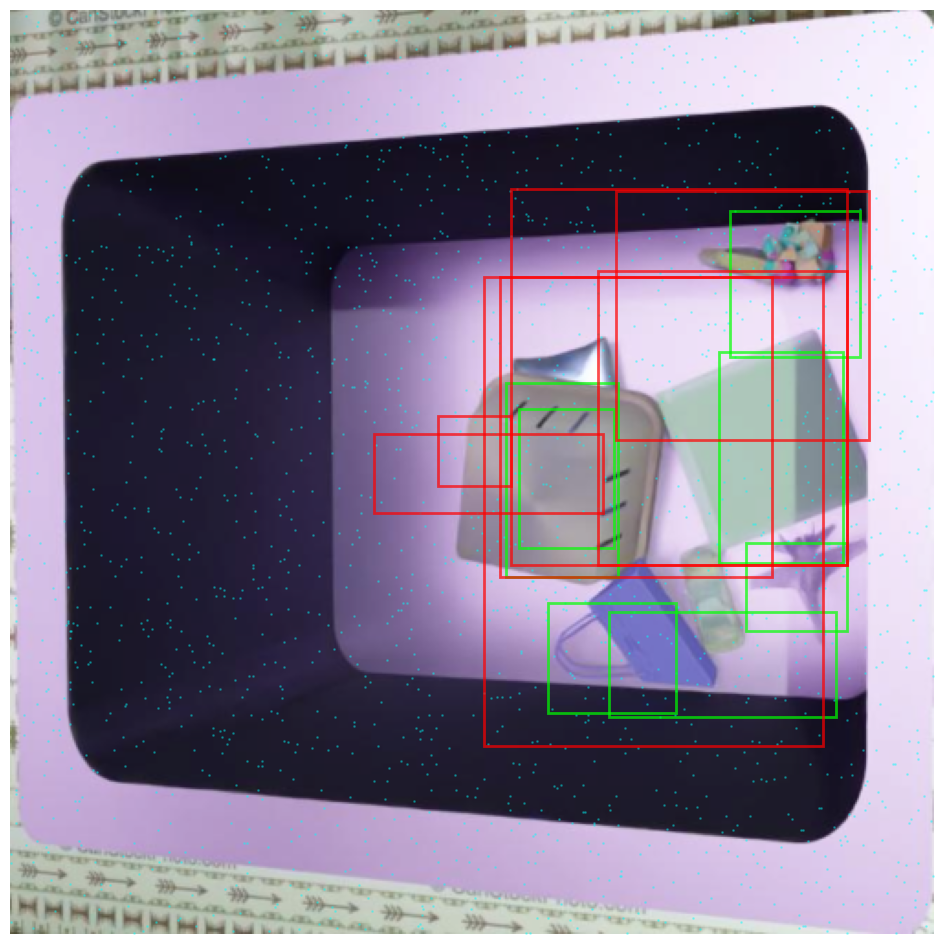

In [18]:
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches

save_dir = "vis_images"
os.makedirs(save_dir, exist_ok=True)

def unnormalize_image(img_tensor):
    mean = np.array([0.485, 0.456, 0.406]).reshape(3,1,1)
    std  = np.array([0.229, 0.224, 0.225]).reshape(3,1,1)
    img = img_tensor.detach().cpu().numpy()
    img = img * std + mean
    img = np.clip(img, 0, 1)
    return img.transpose(1,2,0)

def get_3d_box_corners(box):
    """ box: (7,) [x,y,z,dx,dy,dz,yaw] """
    x,y,z,dx,dy,dz,yaw = box
    # 8 corners in local frame
    corners = np.array([
        [ dx/2,  dy/2,  dz/2],
        [ dx/2, -dy/2,  dz/2],
        [-dx/2, -dy/2,  dz/2],
        [-dx/2,  dy/2,  dz/2],
        [ dx/2,  dy/2, -dz/2],
        [ dx/2, -dy/2, -dz/2],
        [-dx/2, -dy/2, -dz/2],
        [-dx/2,  dy/2, -dz/2],
    ])
    # rotation around z
    c, s = np.cos(yaw), np.sin(yaw)
    R = np.array([[c,-s,0],[s,c,0],[0,0,1]])
    corners = corners @ R.T
    corners += np.array([x,y,z])
    return corners

def project_box_to_image(box, pc_proj):
    """ project 3D box corners into image using nearest point lookup """
    corners = get_3d_box_corners(box)
    H,W = pc_proj.shape[1], pc_proj.shape[2]
    # Flatten pc_proj to list of XYZ with pixel coords
    coords = pc_proj.reshape(3,-1).T  # (H*W, 3)
    uv = np.indices((H,W)).reshape(2,-1).T  # (H*W, 2)

    # For each corner, find nearest point in pc_proj
    uvs = []
    for corner in corners:
        dists = np.linalg.norm(coords - corner, axis=1)
        idx = np.argmin(dists)
        uvs.append(uv[idx])
    return np.array(uvs)

def plot_boxes(image, pc_proj, gt_boxes, pred_boxes, save_path=None):
    fig, ax = plt.subplots(1,1, figsize=(12,12))
    ax.imshow(image)

    # scatter some projected cloud pixels for context
    sample_mask = np.random.choice(pc_proj.shape[1]*pc_proj.shape[2], 2000, replace=False)
    uv = np.indices((pc_proj.shape[1], pc_proj.shape[2])).reshape(2,-1).T
    ax.scatter(uv[sample_mask,0], uv[sample_mask,1], s=1, c='cyan', alpha=0.3)

    # GT (green)
    for box in gt_boxes:
        uvs = project_box_to_image(box, pc_proj)
        if len(uvs)>0:
            min_u, min_v = uvs[:,0].min(), uvs[:,1].min()
            max_u, max_v = uvs[:,0].max(), uvs[:,1].max()
            rect = patches.Rectangle((min_v, min_u), max_v-min_v, max_u-min_u,
                                     linewidth=2, edgecolor='lime', facecolor='none', alpha=0.7)
            ax.add_patch(rect)

    # Pred (red)
    for box in pred_boxes:
        uvs = project_box_to_image(box, pc_proj)
        if len(uvs)>0:
            min_u, min_v = uvs[:,0].min(), uvs[:,1].min()
            max_u, max_v = uvs[:,0].max(), uvs[:,1].max()
            rect = patches.Rectangle((min_v, min_u), max_v-min_v, max_u-min_u,
                                     linewidth=2, edgecolor='red', facecolor='none', alpha=0.7)
            ax.add_patch(rect)

    plt.axis('off')
    if save_path:
        plt.savefig(save_path, bbox_inches='tight')
    plt.show()
    plt.close(fig)

# --- Loop ---
device = next(model.parameters()).device
for idx, samples in enumerate(data_loader):
    for k,v in samples.items():
        samples[k] = v.to(device)
        
    if idx >= 10:
        break

    outputs = model(**samples)
    matched_info = outputs['matched_info'][0]

    img = unnormalize_image(matched_info['img'][0])
    pc_proj = matched_info['pc'][0].cpu().numpy()   # (3,H,W)
    pred_boxes = matched_info['pred_boxes'].detach().cpu().numpy()
    gt_boxes   = matched_info['gt_boxes'].detach().cpu().numpy()
    mask = (gt_boxes.sum(axis=1) != 0)
    gt_boxes = gt_boxes[mask]

    save_path = os.path.join(save_dir, f"sample_{idx:03d}.png")
    plot_boxes(img, pc_proj, gt_boxes, pred_boxes, save_path)
    
